# 基本配置

In [1]:
!pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement imblearn-learn (from versions: none)
ERROR: No matching distribution found for imblearn-learn


## 导入库

In [2]:
import os
import platform
import zipfile
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import albumentations as A
import tensorflow as tf

/Users/weichen/Desktop/GraduationProject/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 设置绘图的中文字体

In [3]:
# # 设置 matplotlib 支持中文显示
# plt.rcParams['font.sans-serif'] = ['SimHei'] if platform.system() == 'Windows' else ['Heiti TC']
# plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# # 测试代码，显示当前字体设置
# print(f"当前字体设置: {plt.rcParams['font.family']}")

## 使用GPU加速

In [4]:
# 检查操作系统
if platform.system() == 'Windows':
    # Windows平台
    # 设置TensorFlow使用Nvidia GPU
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # 设置GPU内存增长，避免占用全部GPU内存
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("正在使用 GPU 运行")
        except RuntimeError as e:
            # 打印异常
            print("发生错误：", e)
elif platform.system() == 'Darwin':
    # MacOS平台
    # 检查是否支持Apple M1芯片GPU
    try:
        # 尝试设置TensorFlow以使用Apple M1芯片的GPU
        if tf.config.list_physical_devices('GPU'):
            print("正在使用 Apple M1 GPU 运行")
        else:
            # 如果没有可用的GPU，将使用CPU
            print("正在使用 CPU 运行")
    except Exception as e:
        print("发生错误：", e)
else:
    # 其他平台，默认使用CPU
    print("正在使用 CPU 运行")

正在使用 Apple M1 GPU 运行


# 解压数据
- Original_dataset 文件夹

In [5]:
# 检查解压目录是否已存在
if not os.path.exists('./BreaKHis_v1'):
    # 解压 zip 文件
    with zipfile.ZipFile('./dataset.zip') as zip_ref:
        zip_ref.extractall('./')
        print('数据集已解压文件夹')
else:
    print('数据集文件已存在，无需解压。')

数据集文件已存在，无需解压。


- BreaKHis_v1
    - BreaKHis_v1
        - histology_slides
            - breast
                - **benign**
                    - **SOB**
                        - 类型
                            - **患者ID**
                                - 40x
                                - 100x
                                - 200x
                                - 400x
                - **malignant**
                    - **SOB**
                        - 类型
                            - **患者ID**
                                - 40x
                                - 100x
                                - 200x
                                - 400x

# 文件读取

In [6]:
def process_dataset(root_dir):
    data = {"image_path": [], "label": [], "zoom_level": []}

    # 遍历'benign'和'malignant'文件夹
    for label in ['benign', 'malignant']:
        label_dir = os.path.join(root_dir, label, "SOB")

        # 遍历每个类型的目录
        for type_dir in os.listdir(label_dir):
            type_dir_path = os.path.join(label_dir, type_dir)

            # 遍历每个患者ID的目录
            for patient_id_dir in os.listdir(type_dir_path):
                patient_dir_path = os.path.join(type_dir_path, patient_id_dir)

                # 遍历每个zoom level的目录
                for zoom_level_dir in os.listdir(patient_dir_path):
                    zoom_dir_path = os.path.join(patient_dir_path, zoom_level_dir)

                    # 遍历zoom级别的目录
                    for img_file in os.listdir(zoom_dir_path):
                        img_file_path = os.path.join(zoom_dir_path, img_file)

                        # 将图像路径，对应的zoom level和标签加入到data字典中
                        data["image_path"].append(img_file_path)
                        data["label"].append(label)
                        data["zoom_level"].append(zoom_level_dir)

    # 创建一个基于data的pandas DataFrame
    df = pd.DataFrame(data)
    return df

In [7]:
root_dir = "./BreaKHis_v1/BreaKHis_v1/histology_slides/breast"
df = process_dataset(root_dir)
df

,image_path,label,zoom_level
0,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X
1,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X
2,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X
3,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X
4,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X
...,...,...,...
7904,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X
7905,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X
7906,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X
7907,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X


## 数据集可视化

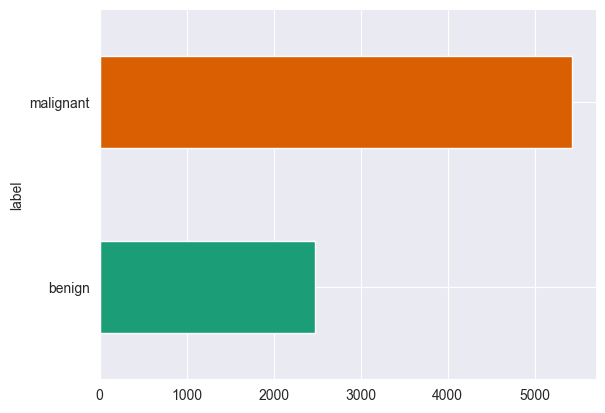

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

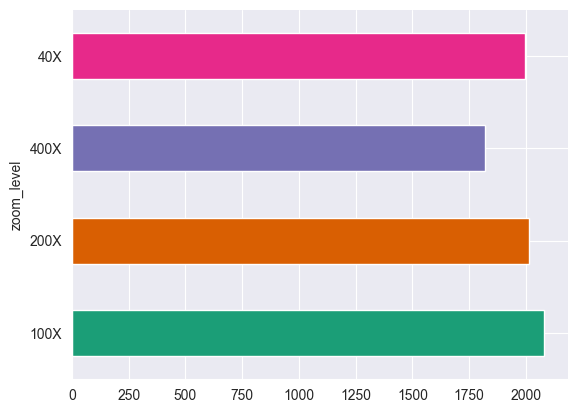

In [9]:
df.groupby('zoom_level').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## 数据集过滤

In [10]:
# df_filtered = df[df['zoom_level'] == '40X']
# df = df_filtered
# df

# 数据集划分
- X_train, X_val, X_test分别包含了训练集、验证集和测试集的图片数据
- y_train, y_val, y_test分别包含了对应的类别标签

**标签转化为整数**

In [11]:
# 创建一个 LabelEncoder 对象
label_encoder = LabelEncoder()

# 使用 fit_transform 方法将类别标签转换为整数
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# 查看编码后的标签对应的原始标签
print(label_encoder.classes_)
df

['benign' 'malignant']


,image_path,label,zoom_level,label_encoded
0,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X,0
1,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X,0
2,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X,0
3,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X,0
4,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X,0
...,...,...,...,...
7904,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X,1
7905,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X,1
7906,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X,1
7907,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X,1


**划分数据集**

In [12]:
# 先将原数据集划分为80%的训练集和20%的（验证集+测试集）
train_df, val_test_df = train_test_split(df, test_size=0.2, stratify=df['label_encoded'])

# 再将（验证集+测试集）均匀划分为验证集和测试集
val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['label_encoded'])

In [13]:
train_df.shape, val_df.shape, test_df.shape

((6327, 4), (791, 4), (791, 4))

# 超参数设置

## 采用滑动平均设置早停
**定义一个基于滑动平均策略的早停规则：当验证损失的滑动平均值在连续10个epoch中没有下降时，训练将停止。**

In [14]:
class EarlyStoppingWithSMA(tf.keras.callbacks.Callback):
    def __init__(self, patience=0, verbose=0):
        super(EarlyStoppingWithSMA, self).__init__()
        self.patience = patience
        self.verbose = verbose
        # 滑动平均的权重
        self.alpha = 0.1
        # 初始化最佳损失为无穷大
        self.best_loss = np.inf
        # 初始化等待计数器
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')
        # 计算损失的滑动平均值
        self.best_loss = self.alpha * current_loss + (1 - self.alpha) * self.best_loss
        if np.less(current_loss, self.best_loss):
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                if self.verbose > 0:
                    print('Epoch {}: early stopping'.format(epoch+1))
early_stopping = EarlyStoppingWithSMA(patience=10, verbose=1)

**TensorBoard回调**
- tensorboard --logdir ./logs
- %load_ext tensorboard
- %tensorboard --logdir ./logs

In [15]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')

## **打包回调函数**

In [16]:
callbacks = [
    early_stopping,
    tensorboard_callback
]

## 类别权重（训练集）
- 首先将使用 compute_class_weight 来为每个类别计算权重。
- 然后，将遍历每个独立的类别，并创建一个字典，其中键是类的标签，值是对应的权重。
- 最后显示生成的 weight_dict 就可以看到每个类别对应的权重。

In [17]:
label_counts = train_df['label_encoded'].value_counts()
total_samples = len(train_df)
class_weights = {class_label: total_samples/count for class_label, count in label_counts.items()}

## 使用余弦退火调整学习率

In [18]:
# 初始学习率
initial_learning_rate = 0.001
# 定义训练步数，这里以一个epoch中样本数据被完全遍历一次作为一步
decay_steps = len(train_df)/32 * 10 # 这个设置将使学习率在大约 10 个 epoch 后衰减到较低的水平

# 定义余弦退火的学习率
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps)

# 创建一个新的 Adam 优化器实例，并使用上述的学习率计划
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

2024-04-30 21:24:21.034423: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-30 21:24:21.034442: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-30 21:24:21.034445: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-30 21:24:21.034462: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-30 21:24:21.034477: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 数据生成器
**对训练集进行数据增强和尺寸转化，同时对训练集、验证集和测试集进行尺寸转换**
parse_image_func 函数负责读取图像并应用适当的预处理和数据增强。它首先读取图像文件，然后解码图像，将其转换为浮点数，然后调整尺寸，如果 augment=True，还会应用数据增强操作。之后，我们使用 tf.data.Dataset.from_tensor_slices 创建一个数据集，然后使用 map 函数应用 parse_func 函数到每个元素。最后，我们使用 batch 和 prefetch 函数来优化数据加载。这个生成器就可以作为模型训练函数的输入使用了。

## 计算权重
- 根据类别标签计算类权重
- 为每个类别分别计算出现的频次，然后用总的样本数除以各个类别的频次，得到各个类别的权重

In [19]:
# class_weights = len(train_df) / train_df['label_encoded'].value_counts()
# class_weights = class_weights.to_dict()

## 数据增强&数据修改

In [20]:
# class_weights = len(train_df) / train_df['label_encoded'].value_counts()
# class_weights = class_weights.to_dict()
# 
# 
# def parse_image_func(img_path, label, img_size=(350,230), weight=None):
#     img = tf.io.read_file(img_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.convert_image_dtype(img, tf.float32)
#     img = tf.image.resize(img, img_size)
#     if weight is not None:
#         img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_flip_up_down(img)
#         img = tf.image.random_crop(img, size=[350, 230, 3])
#         img = tf.image.random_brightness(img, max_delta=0.3)
#         img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
#         img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
#         img = tf.image.rot90(img, k=1) # 旋转图像 90 * k 度
#     return (img, label, weight) if weight is not None else (img, label)
# 
# def create_data_generator(df, batch_size, class_weights=None):
#     image_paths = df['image_path'].values
#     labels = df['label_encoded'].values
#     
#     if class_weights:
#         df['weights'] = df['label_encoded'].map(class_weights) # 注意这部分的修改
#         weights = df['weights'].values
#         dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels, weights))
#         parse_func = lambda img_path, label, weight: parse_image_func(img_path, label, weight)
#     else:
#         dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
#         parse_func = lambda img_path, label: parse_image_func(img_path, label)
# 
#     dataset = dataset.map(parse_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#     dataset = dataset.shuffle(buffer_size=len(df)) if class_weights else dataset  # shuffle only for training
#     dataset = dataset.batch(batch_size)
#     dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
#     return dataset
# 
# batch_size = 32
# 
# train_dataset = create_data_generator(train_df, batch_size, class_weights)
# val_dataset = create_data_generator(val_df, batch_size)
# test_dataset = create_data_generator(test_df, batch_size)

In [21]:
def create_data_generator(df, batch_size, class_weights=None):
    transform = A.Compose([
        A.RandomCrop(width=350, height=230),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=2, min_height=8, min_width=8, fill_value=0, p=0.1)
    ], p=0.5)

    df_batches = np.array_split(df, len(df) // batch_size)

    while True:
        if class_weights is not None:  # shuffle only for train data
            np.random.shuffle(df_batches)

        for batch in df_batches:
            images = []
            labels = []

            for i in range(batch.shape[0]):
                try:
                    img_path = batch.iloc[i]['image_path']
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (350, 230))

                    if class_weights is not None:  # augmentation only for train data
                        img = transform(image=img)["image"]

                    img = img / 255.0 

                    images.append(img)
                    labels.append(batch.iloc[i]['label_encoded'])

                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
                    continue

            if class_weights is not None:
                weights = [class_weights[label] for label in labels]
                yield np.array(images), np.array(labels), np.array(weights)
            else:
                yield np.array(images), np.array(labels)

In [22]:
class_weights = len(train_df) / train_df['label_encoded'].value_counts()
class_weights = class_weights.to_dict()

batch_size = 32
train_dataset = create_data_generator(train_df, batch_size, class_weights)
val_dataset = create_data_generator(val_df, batch_size)
test_dataset = create_data_generator(test_df, batch_size)

**测试数据生成器是否能遍历所有图片数据**

In [ ]:
# 获取一批数据
images, labels, _ = next(train_dataset)

# 根据你的需要，选择展示的图像数量
num_images_to_show = 5

for i in range(num_images_to_show):
    # 展示图像
    plt.imshow(images[i])
    plt.title(f'Label: {labels[i]}')
    plt.show()

# 模型训练 Phase-1
**使用预训练模型VGG16，冻结所有权重，修改输入和输出层**

In [23]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# 加载预训练模型VGG16
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(230, 350, 3))

# 先冻结所有层的权重
for layer in base_model.layers:
    layer.trainable = False

# 建立新的模型
model = Sequential()
# 添加经过预训练的VGG16模型
model.add(base_model)
# 拉平特征图
model.add(Flatten())
# 在全连接层上添加自己的层次
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # 输出层用于二分类

# 编译模型
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [24]:
# 初始阶段的训练
history_initial = model.fit(
    x=train_dataset,  # train_dataset is the generator where included weights.
    steps_per_epoch=len(train_df) // batch_size,  # 一个epoch包含的步骤
    validation_data=val_dataset,  # in validation dataset weights is not included.
    validation_steps=len(val_df) // batch_size,  # 一个epoch的验证步骤
    epochs=20,
    verbose=1,
    callbacks=callbacks
)

/Users/weichen/Desktop/GraduationProject/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Epoch 1/20


2024-04-30 21:24:22.276126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


197/197 ━━━━━━━━━━━━━━━━━━━━ 88s 442ms/step - accuracy: 0.6023 - loss: 2.7624 - val_accuracy: 0.8420 - val_loss: 0.3929
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 87s 443ms/step - accuracy: 0.8172 - loss: 0.8039 - val_accuracy: 0.7560 - val_loss: 0.5184
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 86s 438ms/step - accuracy: 0.8502 - loss: 0.6770 - val_accuracy: 0.8546 - val_loss: 0.3500
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 87s 441ms/step - accuracy: 0.8956 - loss: 0.5376 - val_accuracy: 0.8470 - val_loss: 0.3522
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 87s 440ms/step - accuracy: 0.8932 - loss: 0.5302 - val_accuracy: 0.8306 - val_loss: 0.3777
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 86s 439ms/step - accuracy: 0.8949 - loss: 0.4998 - val_accuracy: 0.8559 - val_loss: 0.3392
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 87s 440ms/step - accuracy: 0.9125 - loss: 0.4639 - val_accuracy: 0.8534 - val_loss: 0.3386
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 86s 439ms/step - accuracy: 0.9321 - loss: 0.3869 - val

# 模型训练 Phase-2
**解冻所有权重，在原有基础上重新训练更新权重**

In [25]:
# 再次解冻模型的一部分层（如最后四层），进行再次训练
# for layer in model.layers[-4:]:
for layer in model.layers:
    layer.trainable = True

# 编译模型
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [26]:
# 初始阶段的训练
history_fine_tune = model.fit(
    x=train_dataset,  # train_dataset is the generator where included weights.
    steps_per_epoch=len(train_df) // batch_size,  # 一个epoch包含的步骤
    validation_data=val_dataset,  # in validation dataset weights is not included.
    validation_steps=len(val_df) // batch_size,  # 一个epoch的验证步骤
    epochs=50,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 86s 436ms/step - accuracy: 0.9350 - loss: 0.3784 - val_accuracy: 0.8534 - val_loss: 0.3386
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 85s 432ms/step - accuracy: 0.9323 - loss: 0.3719 - val_accuracy: 0.8534 - val_loss: 0.3386
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 85s 434ms/step - accuracy: 0.9392 - loss: 0.3496 - val_accuracy: 0.8534 - val_loss: 0.3386
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 85s 433ms/step - accuracy: 0.9392 - loss: 0.3314 - val_accuracy: 0.8534 - val_loss: 0.3386
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 86s 435ms/step - accuracy: 0.9429 - loss: 0.3373 - val_accuracy: 0.8534 - val_loss: 0.3386
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 85s 433ms/step - accuracy: 0.9403 - loss: 0.3683 - val_accuracy: 0.8534 - val_loss: 0.3386
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 86s 435ms/step - accuracy: 0.9367 - loss: 0.3570 - val_accuracy: 0.8534 - val_loss: 0.3386
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 85s 433ms/step - accuracy: 0.9386 - loss: 0

# 模型保存

In [27]:
model.save('vgg16-s20-s50-all.keras')

# 模型测试

In [28]:
# 当训练完毕后，使用测试集进行评估
predictions = model.evaluate(test_dataset, steps=len(test_df) // batch_size, verbose=1)

print('Test loss:', predictions[0])
print('Test accuracy:', predictions[1])

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 383ms/step - accuracy: 0.8732 - loss: 0.3065
Test loss: 0.34228378534317017
Test accuracy: 0.8482933044433594


# 模型评估
- 计算精度（Precision）
- 召回率（Recall）
- F1-Score
- 混淆矩阵（Confusion Matrix）

In [29]:
# 生成预测结果的标签
predict_labels = model.predict(test_dataset, steps=len(test_df) // batch_size, verbose=1)
y_pred_labels = np.argmax(predict_labels, axis=1)

# 如果你的test_dataset没有打乱和重复的话，你只需要取标签就行
test_labels = test_df['label_encoded'].values

# 根据预测结果和真实标签，计算精度、召回率、F1-Score、混淆矩阵等评价指标
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

print('Precision: ', precision_score(test_labels, y_pred_labels, average='macro'))
print('Recall: ', recall_score(test_labels, y_pred_labels, average='macro'))
print('F1-Score: ', f1_score(test_labels, y_pred_labels, average='macro'))

# 混淆矩阵
cm = confusion_matrix(test_labels, y_pred_labels)
print('Confusion Matrix: ', cm)

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 377ms/step
Precision:  0.15676359039190899
Recall:  0.5
F1-Score:  0.2386910490856593
Confusion Matrix:  [[248   0]
 [543   0]]


/Users/weichen/Desktop/GraduationProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
from sklearn.metrics import classification_report

# 模型的 predict 方法会返回每个类别的概率，因此我们需要选择概率最大的类别作为预测的类别
predicted_classes = np.argmax(predictions, axis=1)

# 假设 test_labels 是真实的标签
true_classes = test_dataset[1]

class_names = ['benign', 'malignant']
print(classification_report(true_classes, predicted_classes, target_names=class_names))

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(true_classes, predicted_classes)

# 可视化混淆矩阵
sns.heatmap(cm, cmap='Blues', annot=True, fmt="d", 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**绘制loss和accuracy曲线**

In [ ]:
# 绘制训练 & 验证的损失值
plt.figure()
plt.plot(history_initial.history['loss'] + history_fine_tune.history['loss'])
plt.plot(history_initial.history['val_loss'] + history_fine_tune.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**计算RUC曲线和F1分数**

# 模型测试